## Forecasting Austin Rides with Kats - Forecast distance travelled from landmarks
### Granual level forecasting

In [1]:
import re
import geopy
import statistics
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from kats.consts import TimeSeriesData
from geopy.extra.rate_limiter import RateLimiter
from ipywidgets import interact, interactive, fixed, interact_manual

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
# Load data as pandas dataframe

# Reading only 5000 rows since obtaining full-textual address from lat,long traces takes up a long time
df_A = pd.read_csv("/data/fiona123/Rides_DataA.csv", nrows = 5000)
df_B = pd.read_csv("/data/fiona123/Rides_DataB.csv", nrows = 5000)

df = df_A.merge(df_B)
display(df.head(3))

,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.071,38.655,0,NaN,NaN,2016-06-04 00:14:11-05:00,1.5,25.84,1.5,0.25,2.18,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.038,38.679,0,NaN,NaN,2016-06-04 01:50:02-05:00,1.5,5.00,1.5,0.25,0.41,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,1,NaN,b'REGULAR',NaN,0.0,-121.042,38.678,0,NaN,NaN,2016-06-04 03:16:01-05:00,1.5,5.00,1.5,0.25,0.48,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0


### Preprocessing of data

In [3]:
df['geom'] = df['end_location_lat'].map(str) + ',' + df['end_location_long'].map(str)
display(df.head(5))

,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating,geom
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.071,38.655,0,NaN,NaN,2016-06-04 00:14:11-05:00,1.5,25.84,1.5,0.25,2.18,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039"
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.038,38.679,0,NaN,NaN,2016-06-04 01:50:02-05:00,1.5,5.00,1.5,0.25,0.41,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039"
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,1,NaN,b'REGULAR',NaN,0.0,-121.042,38.678,0,NaN,NaN,2016-06-04 03:16:01-05:00,1.5,5.00,1.5,0.25,0.48,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039"
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.764,30.247,1,NaN,NaN,2016-06-04 10:01:19-05:00,1.5,8.93,1.5,0.25,2.11,NaN,NaN,NaN,NaN,NaN,-97.742,-97.742,NaN,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.271,-97.742"
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.750,30.269,2,NaN,NaN,2016-06-04 10:24:15-05:00,1.5,5.00,1.5,0.25,0.43,NaN,NaN,NaN,NaN,NaN,-97.752,-97.752,NaN,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.269,-97.752"


### Retrieve address from lat,long traces

In [4]:
locator = Nominatim(user_agent="geoLife", timeout=10)
rgeocode = RateLimiter(locator.reverse)

In [5]:
tqdm.pandas()
df['address'] = df['geom'].progress_apply(rgeocode)
display(df.head(5))

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [41:40<00:00,  2.00it/s]


,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating,geom,address
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.071,38.655,0,NaN,NaN,2016-06-04 00:14:11-05:00,1.5,25.84,1.5,0.25,2.18,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","(6298, Edgehill Drive, El Dorado County, Calif..."
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.038,38.679,0,NaN,NaN,2016-06-04 01:50:02-05:00,1.5,5.00,1.5,0.25,0.41,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","(6298, Edgehill Drive, El Dorado County, Calif..."
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,1,NaN,b'REGULAR',NaN,0.0,-121.042,38.678,0,NaN,NaN,2016-06-04 03:16:01-05:00,1.5,5.00,1.5,0.25,0.48,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","(6298, Edgehill Drive, El Dorado County, Calif..."
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.764,30.247,1,NaN,NaN,2016-06-04 10:01:19-05:00,1.5,8.93,1.5,0.25,2.11,NaN,NaN,NaN,NaN,NaN,-97.742,-97.742,NaN,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.271,-97.742","(Prosperity Bank, 900, Congress Avenue, Downto..."
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.750,30.269,2,NaN,NaN,2016-06-04 10:24:15-05:00,1.5,5.00,1.5,0.25,0.43,NaN,NaN,NaN,NaN,NaN,-97.752,-97.752,NaN,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.269,-97.752","(The Monarch, West 5th Street, West Sixth, Aus..."


In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df['address'])

0       (6298, Edgehill Drive, El Dorado County, Calif...
1       (6298, Edgehill Drive, El Dorado County, Calif...
2       (6298, Edgehill Drive, El Dorado County, Calif...
3       (Prosperity Bank, 900, Congress Avenue, Downto...
4       (The Monarch, West 5th Street, West Sixth, Aus...
5       (Canopy by Hilton, 612, West 6th Street, West ...
6       (404, Colorado Street, Downtown, Austin, Travi...
7       (2003, Lightsey Road, South Lamar, Austin, Tra...
8       (Little Texas, Austin, Travis County, Texas, 7...
9       (Austin–Bergstrom International Airport Red Ga...
10      (1200, Guadalupe Street, West Sixth, Austin, T...
11      (Starbucks, West 5th Street, Seaholm, Austin, ...
12      (3513, Lawton Avenue, Military Heights, Austin...
13      (Hotel ZaZa & Residences, 401, Guadalupe Stree...
14      (204, East 6th Street, Downtown, Austin, Travi...
15      (2401, Nueces Street, The Drag, Austin, Travis...
16      (The Long Center for the Performing Arts, 701,...
17      (110, 

In [15]:
df_addr = df.copy()
df_addr['address'] = df_addr['address'].astype(str)

### Extract keywords from address
###  keywords were manually searched and added - could use NLP as a future work

In [16]:
def pattern_searcher(search_str:str, search_list:str):
    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

In [17]:
addr_keywords = ['Drive', 'Bank', 'Airport', 'Street', 'Starbucks','Avenue','office', 'Downtown', 'Inn', 'Station'
                'Campus', 'University', 'Court', 'Market', 'Hotel', 'Plaza', 'Boulevard', 'Mall', 'Theatre',
                'Golf', 'College', 'Bar', 'Cinema', 'Trail', 'Pizzeria', 'Museum', 'Stadium', 'Park', 'Gallery',
                'Club', 'Pizzeria', 'Residences']
pattern = '|'.join(addr_keywords)

df_addr['keyword_addr'] = df_addr['address'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))

In [18]:
display(df_addr.head(5))

# remove NA Values
df_addr_removeNA = df_addr[df_addr['keyword_addr'] != "NA"]
keywords_present = df_addr_removeNA.keyword_addr.unique()

,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating,geom,address,keyword_addr
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.071,38.655,0,NaN,NaN,2016-06-04 00:14:11-05:00,1.5,25.84,1.5,0.25,2.18,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","6298, Edgehill Drive, El Dorado County, Califo...",Drive
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,0,NaN,b'REGULAR',NaN,0.0,-121.038,38.679,0,NaN,NaN,2016-06-04 01:50:02-05:00,1.5,5.00,1.5,0.25,0.41,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","6298, Edgehill Drive, El Dorado County, Califo...",Drive
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,1,NaN,b'REGULAR',NaN,0.0,-121.042,38.678,0,NaN,NaN,2016-06-04 03:16:01-05:00,1.5,5.00,1.5,0.25,0.48,NaN,NaN,NaN,NaN,NaN,-121.039,-121.039,NaN,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0,"38.676,-121.039","6298, Edgehill Drive, El Dorado County, Califo...",Drive
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.764,30.247,1,NaN,NaN,2016-06-04 10:01:19-05:00,1.5,8.93,1.5,0.25,2.11,NaN,NaN,NaN,NaN,NaN,-97.742,-97.742,NaN,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.271,-97.742","Prosperity Bank, 900, Congress Avenue, Downtow...",Bank
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,2,NaN,b'REGULAR',NaN,0.0,-97.750,30.269,2,NaN,NaN,2016-06-04 10:24:15-05:00,1.5,5.00,1.5,0.25,0.43,NaN,NaN,NaN,NaN,NaN,-97.752,-97.752,NaN,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0,"30.269,-97.752","The Monarch, West 5th Street, West Sixth, Aust...",Street


### User defined location to forecast

In [19]:
def f(location):
    global df_addr_loc, selected_loc
    selected_loc = location
    df_addr_loc = df_addr_removeNA[df_addr_removeNA['keyword_addr'] == location]
    display(df_addr_loc.head(5))
val = interact(f, location=keywords_present)

interactive(children=(Dropdown(description='location', options=('Drive', 'Bank', 'Street', 'Airport', 'Starbuc…

### Train and predict using the KATS Ensemble model

In [20]:
# Define the Ensemble model

from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet,  # requires fbprophet be installed
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
# here we include 6 different models
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("prophet", prophet.ProphetParams()),  # requires fbprophet be installed
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

### Forecast distance travelled in the future from a specified landmark
#### Helps understand the demand and how far the riders travel from certain locations, this is propotional to the cab fare paid at the end of travel.

/data/fiona123/kats_jup/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,active_driver_id,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,driving_time_to_rider,dispatch_location_lat,dispatch_location_long,driving_distance_to_rider,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating,geom,address,keyword_addr,started_on_date
68,68,2016-06-08 08:38:06-05:00,2016-06-08 08:31:22-05:00,2016-06-08 08:54:19-05:00,2016-06-08 08:52:16-05:00,9791.0,30.237,-97.704,5.0,5.0,45,NaN,b'REGULAR',NaN,0.0,-97.745,30.282,23,0.0,NaN,2016-06-08 08:38:03-05:00,1.5,15.84,1.5,0.25,3.55,2016-06-08 03:31:28-05:00,NaN,NaN,NaN,NaN,-97.704,-97.704,NaN,2016-06-08 13:31:22,b'DISPATCHED',9,9,b'Brown',b'BMW',b'X5',b'2013',5,5.00,"30.237,-97.704","Austin Community College - Riverside Campus, G...",College,2016-06-08
164,164,2016-06-10 07:36:36-05:00,2016-06-10 07:36:23-05:00,2016-06-10 07:43:19-05:00,2016-06-10 07:43:00-05:00,8669.0,30.237,-97.704,5.0,5.0,92,NaN,b'REGULAR',NaN,0.0,-97.735,30.216,23,0.0,NaN,2016-06-10 07:36:32-05:00,1.5,12.81,1.5,0.25,1.60,2016-06-10 02:36:27-05:00,NaN,NaN,NaN,NaN,-97.704,-97.704,NaN,2016-06-10 12:36:23,b'DISPATCHED',13,13,b'Brown',b'Ford',b'Explorer',b'2013',7,4.71,"30.237,-97.704","Austin Community College - Riverside Campus, G...",College,2016-06-10
969,969,2016-06-18 02:45:53-05:00,2016-06-18 02:39:57-05:00,2016-06-18 21:35:13-05:00,2016-06-18 02:56:20-05:00,5204.0,30.235,-97.744,5.0,5.0,496,NaN,b'REGULAR',NaN,0.0,-97.744,30.268,354,0.0,NaN,2016-06-18 02:45:38-05:00,1.5,10.57,1.5,0.25,2.62,2016-06-17 21:40:30-05:00,NaN,NaN,NaN,NaN,-97.744,-97.744,NaN,2016-06-18 07:39:57,b'DECLINED',94,94,b'White',b'Toyota',b'Camry',b'2002',1,5.00,"30.235,-97.744","Travis Early College High School, 1211, East O...",College,2016-06-18
1076,1076,2016-06-18 18:36:25-05:00,2016-06-18 18:28:24-05:00,2016-06-18 19:00:25-05:00,2016-06-18 18:46:15-05:00,2605.0,30.292,-97.736,NaN,5.0,552,NaN,b'REGULAR',NaN,0.0,-97.749,30.287,583,0.0,NaN,2016-06-18 18:36:20-05:00,1.5,7.97,1.5,0.25,2.46,2016-06-18 13:28:31-05:00,NaN,NaN,NaN,NaN,-97.736,-97.736,NaN,2016-06-18 23:28:24,b'DISPATCHED',107,107,b'Red',b'Kia',b'Optima',b'2014',1,4.87,"30.292,-97.736","Animal Resource Center, 2701, Speedway, Colleg...",College,2016-06-18
1271,1271,2016-06-18 23:32:52-05:00,2016-06-18 23:31:06-05:00,2016-06-18 23:42:06-05:00,2016-06-18 23:42:03-05:00,4072.0,30.291,-97.733,NaN,5.0,619,NaN,b'REGULAR',NaN,0.0,-97.754,30.272,675,0.0,NaN,2016-06-18 23:32:29-05:00,1.5,9.19,1.5,0.25,2.30,2016-06-18 18:31:10-05:00,NaN,NaN,NaN,NaN,-97.733,-97.733,NaN,2016-06-19 04:31:07,b'DISPATCHED',111,111,b'Black',b'Hyundai',b'Sonata Hybrid',b'2013',1,4.91,"30.291,-97.733","603, Bellevue Place, College Court, Austin, Tr...",College,2016-06-18


,value,time
2016-06-08,9791.000000,2016-06-08
2016-06-09,3960.333333,2016-06-09
2016-06-10,8669.000000,2016-06-10
2016-06-11,3960.333333,2016-06-11
2016-06-12,3960.333333,2016-06-12
2016-06-13,3960.333333,2016-06-13
2016-06-14,3960.333333,2016-06-14
2016-06-15,3960.333333,2016-06-15
2016-06-16,3960.333333,2016-06-16
2016-06-17,3960.333333,2016-06-17


/data/fiona123/kats_jup/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/data/fiona123/kats_jup/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
     

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56754D+00    |proj g|=  1.98684D-02

At iterate    5    f=  9.56655D+00    |proj g|=  4.46878D-03

At iterate   10    f=  9.56554D+00    |proj g|=  7.51399D-04

At iterate   15    f=  9.56554D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     25      1     0     0   1.776D-07   9.566D+00
  F =   9.5655380144165232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

Initial

 This problem is unconstrained.


Iteration 29. Log joint probability =    34.3074. Improved by 4.84639e-06.
Iteration 30. Log joint probability =    34.3074. Improved by 4.04266e-07.
Iteration 31. Log joint probability =    34.3074. Improved by 6.55472e-06.
Iteration 32. Log joint probability =    34.3074. Improved by 2.09765e-06.
Iteration 33. Log joint probability =    34.3074. Improved by 3.37988e-06.
Iteration 34. Log joint probability =    34.3074. Improved by 1.11374e-06.
Iteration 35. Log joint probability =    34.3074. Improved by 1.87692e-06.
Iteration 36. Log joint probability =    34.3074. Improved by 1.1323e-06.
Iteration 37. Log joint probability =    34.3074. Improved by 3.42632e-07.
Iteration 38. Log joint probability =    34.3074. Improved by 1.42922e-07.
Iteration 39. Log joint probability =    34.3074. Improved by 1.31453e-07.
Iteration 40. Log joint probability =    34.3074. Improved by 1.29935e-07.
Iteration 41. Log joint probability =    34.3074. Improved by 9.95335e-08.
Iteration 42. Log joint pr

/data/fiona123/kats_jup/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




Text(0.5, 1.0, 'Average Distance travelled (in metres) from location:College')

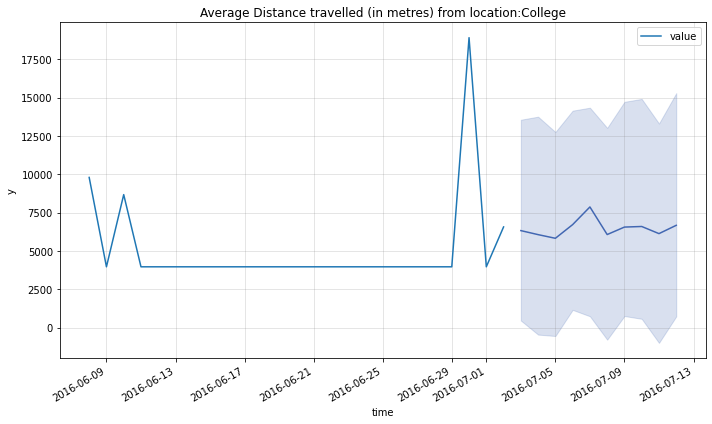

In [22]:
# Preprocess the data to fit into the expected input type of Kats Ensemble model

df_addr_loc['started_on_date'] = df_addr_loc['started_on'].str[:10]
display(df_addr_loc.head(5))

count_df = pd.DataFrame()

# Mean calculation to handle missing values
count_df['value'] = df_addr_loc.groupby(['started_on_date'])['distance_travelled'].transform('mean')
count_df['time'] = df_addr_loc.started_on_date

# Remove duplicate datetime
new_count_df = count_df.drop_duplicates(subset=['time'])

# Sort dataframe by time
new_count_df = (new_count_df.groupby(new_count_df['time'], sort=False, group_keys=False)
         .apply(lambda x: x.sort_values('time')))
new_count_df.set_index('time', inplace=True)
new_count_df.index = pd.to_datetime(new_count_df.index)

# Fill the gaps in timeseries to avoid Frequency errors in KatsEnsemble model.fit()
start = new_count_df.head(1).index.item()
end = new_count_df.tail(1).index.item()
add_dates_df = pd.DataFrame()  
add_dates_df.index = pd.date_range(start, end)
add_dates_df.index = pd.to_datetime(add_dates_df.index)

full_series_df = pd.concat([add_dates_df, new_count_df], axis=1)
full_series_df['time'] = full_series_df.index
full_series_df['value'].fillna(full_series_df['value'].mode()[0], inplace=True)
display(full_series_df)

timeseries = TimeSeriesData(full_series_df)

# create `KatsEnsemble` model
model = KatsEnsemble(
    data=timeseries, 
    params=KatsEnsembleParam
    )

# fit and predict
model.fit()

# predict for the next 10 steps
fcst = model.predict(steps=10)

# aggregate individual model results
model.aggregate()

# plot to visualize
ax1 = model.plot()
timeseries.plot(ax=ax1)
plt.grid()
plt.title("Average Distance travelled (in metres) from location:" + selected_loc)